In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack, csr_matrix
import math

# **Dataset**
- 20000263 ratings
- 465564 tag applications
- 27278 movies.
- These data were created by 138493 users between 1/9/1995 and 3/31/2015

Users were selected at random for inclusion. All selected users had rated at least 20 movies.

In [ ]:
rating_df = pd.read_csv('../input/movielens-20m-dataset/rating.csv')
movie_df = pd.read_csv('../input/movielens-20m-dataset/movie.csv')

# **Data analysis**

In [ ]:
rating_df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [ ]:
movie_df


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


**Check for null values**

In [ ]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

**Check for duplicated values**

In [ ]:
rating_df.duplicated().sum()

0

In [ ]:
movie_df.duplicated().sum()

0

**check unique values**

In [ ]:
movie_df.nunique()

movieId    27278
title      27262
genres      1342
dtype: int64

In [ ]:
rating_df.nunique()

userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64

In [ ]:
print('Mean rating of a movie:',rating_df['rating'].mean())

Mean rating of a movie: 3.5255285642993797


In [ ]:
# userId: Unique Id provided for each user.
print('Number of users:', rating_df['userId'].nunique())
print('Mean number of ratings for each user:', rating_df.groupby(by='userId').size().mean())

Number of users: 138493
Mean number of ratings for each user: 144.4135299257002


In [ ]:
rating_df['rating'].value_counts()

rating
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: count, dtype: int64

# **Data preprocessing**

In [ ]:
# Extract the release year from the movie titles
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)')

In [ ]:
movie_df['year']

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
27273    2007
27274    2002
27275    2014
27276    2001
27277    2014
Name: year, Length: 27278, dtype: object

In [ ]:
movie_df['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1988', '1967', '1993',
       '1964', '1977', '1965', '1982', '1985', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1959', '1968', '1980', '1975', '1986', '1948', '1943', '1950',
       '1946', '1987', '1997', '1974', '1956', '1958', '1949', '1972',
       '1998', '1933', '1952', '1951', '1957', '1961', '1954', '1934',
       '1944', '1963', '1942', '1941', '1953', '1939', '1947', '1945',
       '1938', '1935', '1936', '1926', '1932', '1979', '1971', '1978',
       '1966', '1962', '1983', '1984', '1931', '1922', '1999', '1927',
       '1929', '1930', '1928', '1925', '1914', '2000', '1919', '1923',
       '1920', '1918', '1921', '2001', '1924', '2002', '2003', '1915',
       '2004', '1916', '1917', '2005', '2006', '1902', nan, '1903',
       '2007', '2008', '2009', '1912', '2010', '1913', '2011', '1898',
       '1899', '1894', '2012', '1909', '1910', '1901', '1893', '2013',
       '1

In [ ]:
movie_df.isnull().sum()

movieId     0
title       0
genres      0
year       22
dtype: int64

In [ ]:
# Remove any movies without a valid year of release
movie_df.dropna(subset=['year'], inplace=True)

In [ ]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
year       0
dtype: int64

In [ ]:
movie_df

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,2007
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,2002
27275,131258,The Pirates (2014),Adventure,2014
27276,131260,Rentun Ruusu (2001),(no genres listed),2001


In [ ]:
# Extract genres

# Split the "genres" column into multiple columns using get_dummies()
genres_df = movie_df['genres'].str.get_dummies('|')
print('These are the available genres:\n',genres_df.columns.values)

These are the available genres:
 ['(no genres listed)' 'Action' 'Adventure' 'Animation' 'Children' 'Comedy'
 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'IMAX'
 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


In [ ]:
genres_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27274,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27275,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27276,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Visualize the data**

In [ ]:
# the number of movies per genre
movies_per_genre= genres_df.sum()
print(movies_per_genre)

(no genres listed)      237
Action                 3519
Adventure              2329
Animation              1027
Children               1139
Comedy                 8369
Crime                  2938
Documentary            2467
Drama                 13340
Fantasy                1411
Film-Noir               330
Horror                 2611
IMAX                    196
Musical                1035
Mystery                1513
Romance                4127
Sci-Fi                 1741
Thriller               4177
War                    1194
Western                 676
dtype: int64


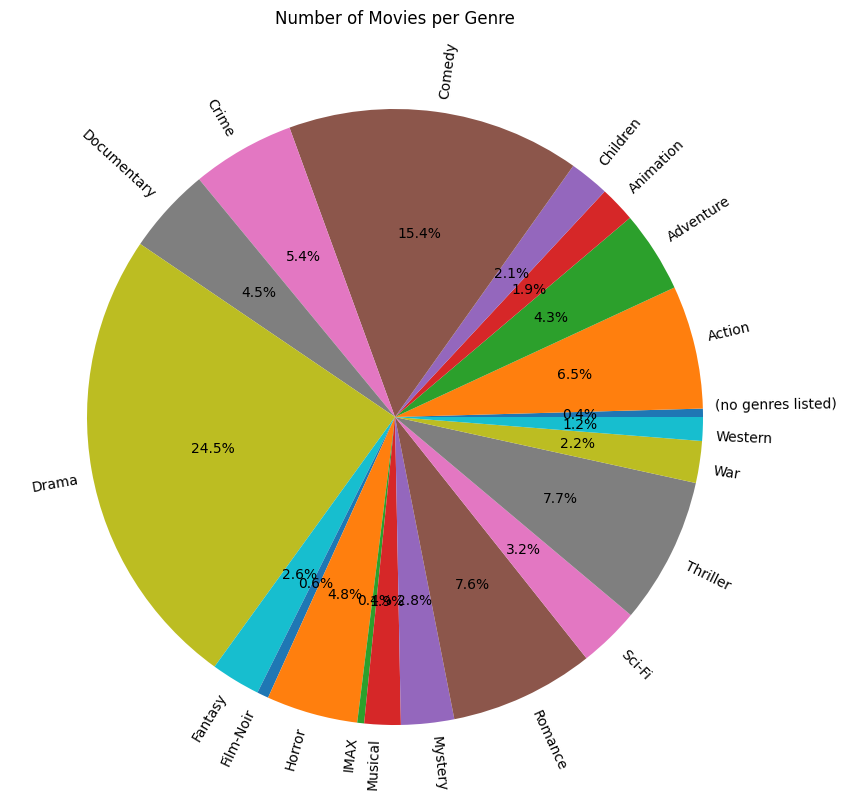

In [ ]:
# Plot the # movies by genre
plt.figure(figsize=(50, 10))
plt.pie(movies_per_genre, labels=movies_per_genre.index, autopct='%.1f%%', labeldistance=1.04, rotatelabels=True)

plt.title('Number of Movies per Genre')
plt.show()

drama is the movie type that people watch the most

In [ ]:
# movies released each year
movie_df.groupby('year').title.count()

year
1891       1
1893       1
1894       2
1895       2
1896       2
        ... 
2011    1016
2012    1022
2013    1011
2014     740
2015     120
Name: title, Length: 118, dtype: int64

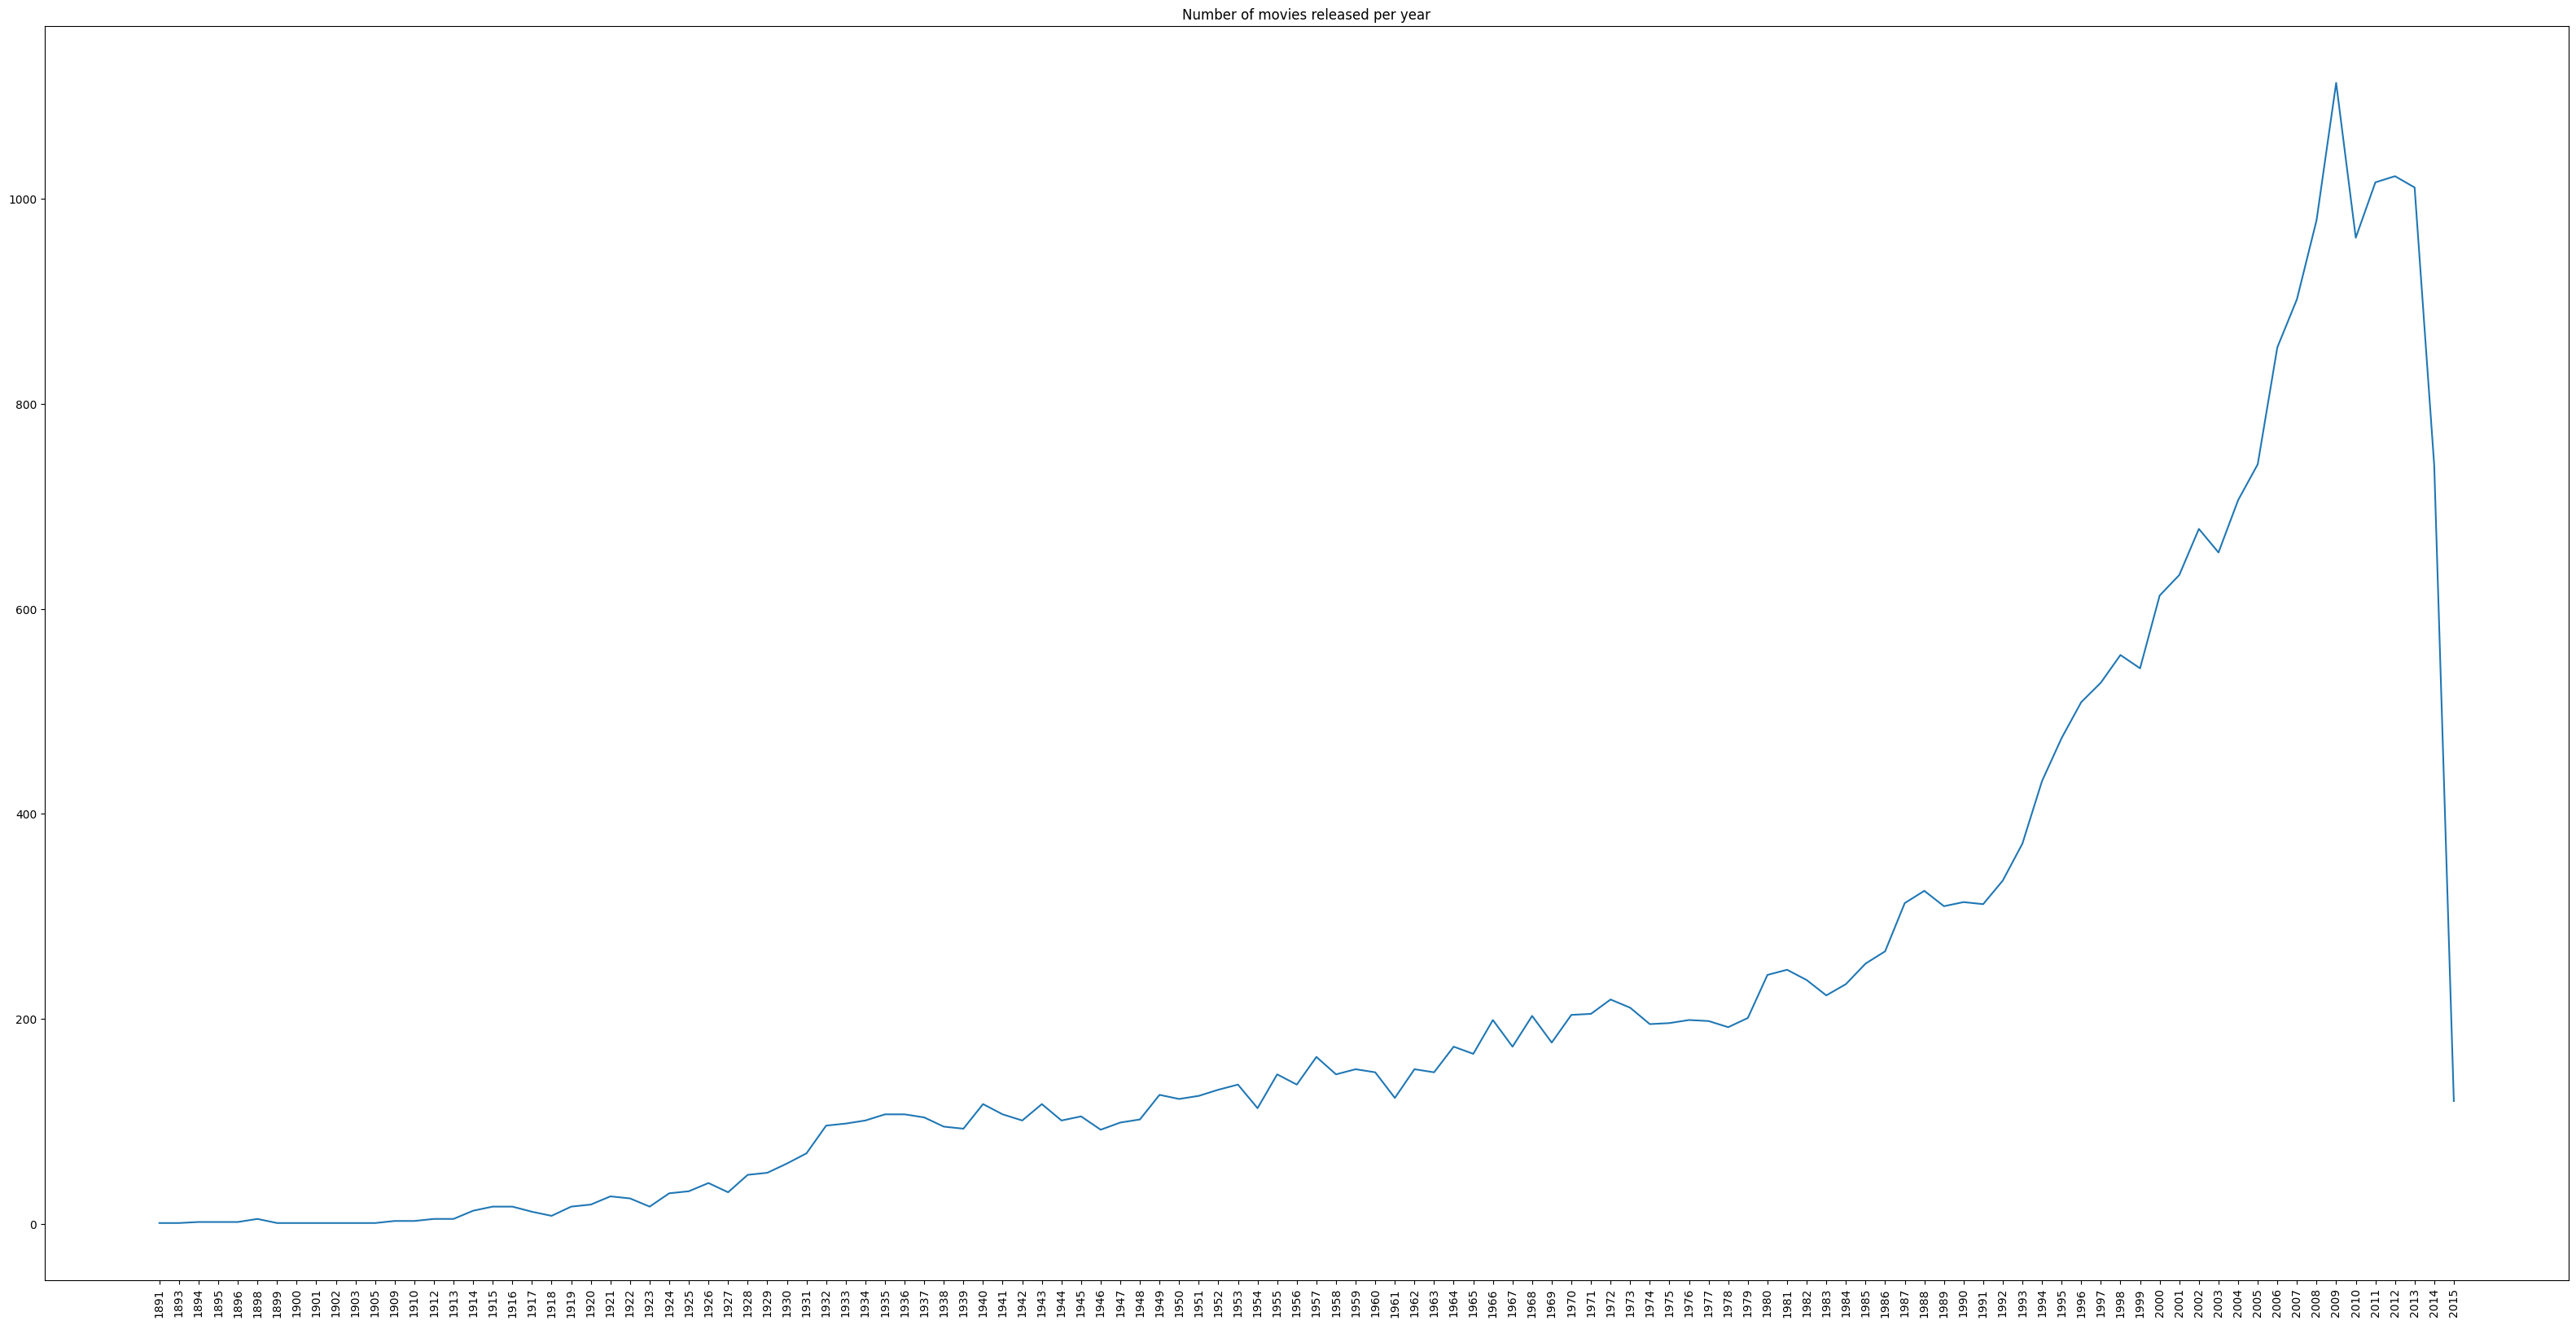

Max No.of Movies Relesed = 1113
Year = 2009


In [ ]:
# Plot the # movies released each year
plt.figure(figsize=(40, 20))
plt.plot(movie_df.groupby('year').title.count())
plt.xticks(rotation=90)
plt.title('Number of movies released per year')
plt.show()

a=movie_df.groupby('year').title.count()
print('Max No.of Movies Relesed =',a.max())
for i in a.index:
    if a[i] == a.max():
        print('Year =',i)

# **Content based filtering**

In [ ]:
movie_df

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,2007
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,2002
27275,131258,The Pirates (2014),Adventure,2014
27276,131260,Rentun Ruusu (2001),(no genres listed),2001


In [ ]:
rating_df.drop(['timestamp'], axis=1, inplace= True)

In [ ]:
# Drop title and genres features
movies_features = movie_df.drop(['title', 'genres'], axis=1, inplace=False)

In [ ]:
# Merge with genres
movies_features = movies_features.merge(genres_df, left_index=True, right_index=True)

In [ ]:
movies_features

,movieId,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,2007,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27274,131256,2002,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27275,131258,2014,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27276,131260,2001,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movies_features.iloc[:, 2:]

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27274,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27275,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27276,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Next, for each movie that the user has rated, we need to find the top K most similar movies based on the computed similarities. We are going to use the KNeighborsClassifier.**

In [ ]:
import math
math.sqrt(len(movies_features))

165.09391266791152

In [ ]:
model = NearestNeighbors(n_neighbors=15, metric='cosine')
model.fit(movies_features.iloc[:, 2:])

NearestNeighbors(metric='cosine', n_neighbors=15)

In [ ]:
# Define a function to recommend movies based on a given movie
def recommend_movies(movie_idx, features, model):
    # Find the n nearest neighbors based on the cosine similarity
    # Returns indices of and distances to the neighbors of each point.
    distances, indices = model.kneighbors(features)

    # Get the attributes of the nearest neighbor movies
    recommended_movies = pd.DataFrame([movie_df.iloc[idx] for idx in indices.flatten()]) # indices.flatten(): Return a copy of the array collapsed into one dimension.
    recommended_movies['distance'] = distances.flatten()

    # Print the recommended movies
#     print(movies.loc[movie_idx])
#     print("Movies similar to", find_title_by_idx(movie_idx), ":\n")
#     print(recommended_movies)
    # Return the recommended movies
    return recommended_movies

In [ ]:
def find_idx_by_title(title):
    idx = movie_df[movie_df['title'] == title].index
    return idx[0]

In [ ]:
def find_title_by_idx(idx):
    title = movie_df.loc[idx]['title']
    return title

In [ ]:
# Test recs on "Toy Story (1995)" :
index = find_idx_by_title("Toy Story (1995)")

feature=pd.DataFrame(movies_features.iloc[index, 2:]).transpose()
recommend_movies(index, feature, model)

,movieId,title,genres,year,distance
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0.0
24458,115875,Toy Story Toons: Hawaiian Vacation (2011),Adventure|Animation|Children|Comedy|Fantasy,2011,0.0
18274,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,2006,0.0
3922,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,2000,0.0
3663,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,2000,0.0
3027,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1999,0.0
24092,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,1992,0.0
24156,114552,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy,2014,0.0
10987,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,2006,0.0
24460,115879,Toy Story Toons: Small Fry (2011),Adventure|Animation|Children|Comedy|Fantasy,2011,0.0
